In [2]:
#add library to the path
import os
import sys
import glob
cwd = os.getcwd()
path = cwd.split("eng")[0]+"eng/"
sys.path.append(path)

import pprint
pp = pprint.PrettyPrinter(indent=2)

#np, random and matplotlib
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import json
from matplotlib import rc
from matplotlib.lines import Line2D
plt.rcParams['font.size'] = 9
import copy
import pandas as pd

# Load data and combine into dictionary

In [3]:
%%time
def compress2name(dc, compress):
    t = tuple([dc, compress])
    
    name_dic = {('Any', False): 'mu=2',
                  ('Any', 'F'): 'mu=2',
                  ('Any+Ising', 'F'): 'nu,d_J=2,2',
                  ('Any+Ising', False): 'nu,d_J=2,2',
                  ('Any+Manhattan', 'T'): False,
                  ('Any+Manhattan', False): 'nu,d_J=2,3',
                  ('Any+Species', 'T'): False,
                  ('Any+Species', True): False,
                  ('Manhattan+Species', 'T'): False,
                  ('Species', 'ANY'): 'nu,mu=1,1',
                  ('Species', 'F'): 'nu=2',
                  ('Species', 'REBIN'): 'nu,mu*=1,1',
                  ('Species', 'SPHERE'): 'nu,hat{mu}=1,1',
                  ('Species', 'T'): 'W^TP_l',
                  ('Species', 'RC'): 'W^TP_l',
                  ('Species', False): 'nu=2',
                  ('Species', True): 'W^TP_l',
                  ('Species', 'SYM'): False}
    
    
    return name_dic[t]

def nu2name(nu):
    nu = str(nu)
    if nu == "1":
        return 'nu,mu=1,1'
    elif nu == "2":
        return 'nu=2'
    elif nu == "0":
        return 'mu=2'
    elif nu == "Ising":
        return 'nu,d_J=2,2'
    
def origin_file2zeta(of):
    #print(of)
    if "LRR" in of:
        return 1
    elif "zeta=" in of:
        s = of.split("zeta=")[-1]
        s = s.split("_Ntrain")[0]
        #print("s is", s)
        return round(float(s))

dataset_names = ["QM9", "amino", "elpasolites", "Li-TM", "QM9_ACSF", "Li-TM_ACSF"]
combined_fol = "data/"

all_data = {}
all_names = set()
for dataset_name in dataset_names[:]:
    all_ds = []
    jf = combined_fol + dataset_name + ".json"
    with open(jf, "r") as f:
        json_string = f.read() 
    data = json.loads(json_string)
    dic = dict()
    for d in data:
        for x in d:
            #extract required values
            of = x["origin_file"]
            results = x["results"]
            model = x["model"]

            #extract name, zeta, N_train, lambda and results
            #extract name, zeta, N_train, lambda and results
            if "density_channels" in x["model"]["SOAP_params"]:
                dc = x["model"]["SOAP_params"]["density_channels"]
                c = x["model"]["SOAP_params"]["compress"]
                name = compress2name(dc, c)
            else:
                nu = model["SOAP_params"]["nu"]
                name = nu2name(nu)
            all_names.add(name)
            zeta = origin_file2zeta(of)
            lam = str(model["lamb"])
            N = results["N_train"]
            
            #add to dic
            if name not in dic:
                dic[name] = {}
            if zeta not in dic[name]:
                dic[name][zeta] = {}
            if N not in dic[name][zeta]:
                dic[name][zeta][N] = {}
            if lam not in dic[name][zeta][N]:
                dic[name][zeta][N][lam] = []
            
            dic[name][zeta][N][lam].append(results)
    all_data[dataset_name] = dic
print(all_names)

{False, 'mu=2', 'nu,mu*=1,1', 'nu,d_J=2,3', 'nu,mu=1,1', 'W^TP_l', 'nu,hat{mu}=1,1', 'nu=2', 'nu,d_J=2,2'}
CPU times: user 18.7 s, sys: 1.58 s, total: 20.3 s
Wall time: 22.6 s


# K-fold cross validation for each model, Ntrain, error metric

In [4]:
%%time 
i = 0
all_kfold = {}
for dataset_name, dic in all_data.items():
    print(dataset_name)
    all_kfold[dataset_name] = {}
    for name, d1 in dic.items():
        all_kfold[dataset_name][name] = {}
        for zeta, d2 in d1.items():
            all_kfold[dataset_name][name][zeta] = []
            for N, d3 in d2.items():
                bd = {}
                temp = {}
                for lamb, d4 in d3.items():
                    df = pd.DataFrame(d4)
                    n_rows = len(df)
                    mean = dict(df.mean(axis=0))
                    std = dict(df.std(axis=0))
                    for err, mean_val in mean.items():
                        if not ("MAE" in err or "RMSE" in err):
                            continue
                        std_val = std[err]
                        if err not in temp:
                            temp[err] = []
                        temp[err].append([lamb, mean_val, std_val/(n_rows-1)**0.5])
                        
                for err, lst in temp.items():
                    lst = sorted(lst, key=lambda x: float(x[1]))
                    best = lst[0]
                    bd[err] = best[1:]
                bd["N_train"] = N
                all_kfold[dataset_name][name][zeta].append(bd)
            all_kfold[dataset_name][name][zeta] = pd.DataFrame(all_kfold[dataset_name][name][zeta])
            
            #print out one example data frame. cell values = mean, standard deviation
            #if i < 1:
            #    display(pd.DataFrame(all_kfold[dataset_name][name][zeta]))
            #    i += 1

QM9
amino
elpasolites
Li-TM
QM9_ACSF
Li-TM_ACSF
CPU times: user 1min 3s, sys: 352 ms, total: 1min 3s
Wall time: 1min 3s


# Plotting colors, lengths etc

In [5]:
cdic = {'nu,hat{mu}=1,1': 'C1', 'nu,d_J=2,3': 'C6', 'nu=2': 'C3', 'mu=2': 'C0', 'nu,mu*=1,1': 'C4', 'nu,d_J=2,2': 'C9', 'nu,mu=1,1': 'C2', 'W^TP_l': 'k'}

def name2label(name):
    symbols = ["nu", "mu", "hat"]
    for s in symbols:
        name = name.replace(s, "\\"+s)
    return "$"+name+"$"

def get_len(name, N, L, S, S2=None):
    len_dic = {}
    len_dic["nu=2"] = 1/2*N*S*(N*S+1)*(L+1)
    len_dic["mu=2" ] = 1/2*N*(N+1)*(L+1)
    len_dic["nu,hat{mu}=1,1"] = N*S*(L+1)
    len_dic["nu,mu=1,1"] = N**2*S*(L+1)
    len_dic["W^TP_l"] = N*S*(L+1)**2
    len_dic["nu,mu*=1,1"] = N*S*(L+1)**2
    len_dic["nu,d_J=2,2"] = 1/2*N*2*(N*2+1)*(L+1)
    len_dic["nu,d_J=2,3"] = 1/2*N*3*(N*3+1)*(L+1)

    if S2 is not None:
        S = S2
    sparse_dic = {}
    sparse_dic["nu=2"] = 1/2*N*S*(N*S+1)*(L+1)
    sparse_dic["nu,hat{mu}=1,1"] = N*S*(L+1)
    sparse_dic["nu,mu=1,1"] = N**2*S*(L+1)
    sparse_dic["W^TP_l"] = N*S*(L+1)**2
    sparse_dic["nu,mu*=1,1"] = N*S*(L+1)**2
    sparse_dic["nu,d_J=2,2"] = 0
    sparse_dic["nu,d_J=2,3"] = 0
    sparse_dic["mu=2" ] = 0
    
    return len_dic[name], sparse_dic[name]
    

# 4 Energy fits using the SOAP power spectrum

# QM9

<IPython.core.display.Javascript object>


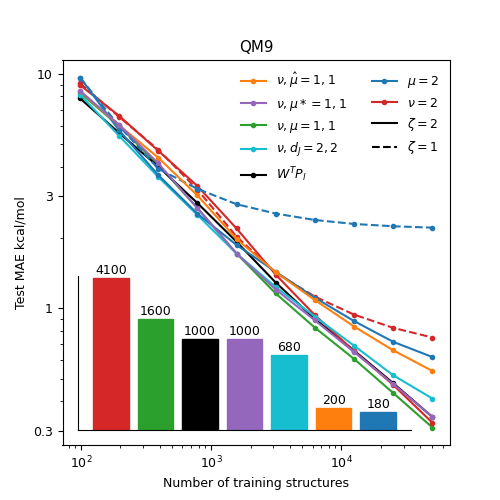

In [6]:
error_key = "total_test_MAE"
Energy_unit = "kcal/mol"
Econv = 627.5
Nmin = 90

i = 0
data = all_kfold["QM9"]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

bar_labels = []
for name, d1 in data.items():
    for zeta, d2 in d1.items():
        #only draw selected lines
        if not (zeta > 1.5 or name in ["nu=2", "mu=2"]):
            continue
        if name not in bar_labels:
            bar_labels.append(name)
        
        label=name2label(name)
        if zeta > 1.5:
            ls = "-"
        else:
            ls = "--"
            label = None
        
        #plotting
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: x[0])
        pdata = np.array(pdata)
        ax.plot(pdata[:,0], Econv*pdata[:,1], label=label, c=cdic[name], ls=ls, marker="o", markersize=3)
        
#set the axes scales
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of training structures")
ylabel = "Test "
for x in ["MAE", "RMSE"]:
    if x in error_key:
        ylabel += x
ax.set_ylabel(ylabel + " "+Energy_unit)
ax.legend(ncol=2)
ax.set_title("QM9")

ys = [0.3, 1, 3, 10]
ax.set_yticks(ys)
ax.set_yticklabels([str(y) for y in ys])


#adjust the legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key = lambda t: (-len(t[0]), t[0])))
solid_line = Line2D([0], [0], label='manual line', color='k', ls="-")
dashed_line = Line2D([0], [0], label='manual line', color='k', ls="--")
handles = list(handles) + [solid_line, dashed_line]
labels = list(labels) + [r"$\zeta=2$", r"$\zeta=1$"]
ax.legend(handles, labels, ncol=2, frameon=False, loc="upper right")


#add the bar chart
N = 8
L = 4
S = 5
gs = fig.add_gridspec(50, 50)
ax3 = fig.add_subplot(gs[28:48, 2:45])
all_bar_values = [get_len(name, N, L, S) for name in bar_labels]
bar_values = [x[0] for x in all_bar_values]
bar_labels, bar_values = zip(*sorted(zip(bar_labels, bar_values), key = lambda x: -x[1]))

barlist = ax3.bar([name2label(name) for name in bar_labels], bar_values)
for i, lab in enumerate(bar_labels):
    barlist[i].set_color(cdic[lab])


ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)
ax3.set_facecolor((1,1,1,0))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_ylim([120,None])
ax3.set_yscale("log")
ax3.yaxis.set_ticklabels([])

ind = 0
for label, val in zip(bar_labels, bar_values):
    ax3.text(ind, val*1.1, str(int(val)), ha="center")
    ind += 1
    
plt.savefig("Plots/QM9.pdf")

# Amino Acids

<IPython.core.display.Javascript object>


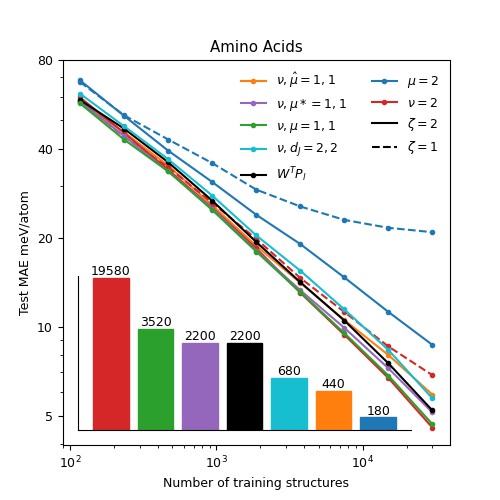

In [7]:
error_key = "per_atom_test_MAE"
Energy_unit = "meV/atom"
Econv = 1000
Nmin = 90

i = 0
data = all_kfold["amino"]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

bar_labels = []
for name, d1 in data.items():
    for zeta, d2 in d1.items():
        #only draw selected lines
        if not (zeta > 1.5 or name in ["nu=2", "mu=2"]):
            continue
        if name not in bar_labels:
            bar_labels.append(name)
        
        label=name2label(name)
        if zeta > 1.5:
            ls = "-"
        else:
            ls = "--"
            label = None
        
        #plotting
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: x[0])
        pdata = np.array(pdata)
        ax.plot(pdata[:,0], Econv*pdata[:,1], label=label, c=cdic[name], ls=ls, marker="o", markersize=3)
        
#set the axes scales
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of training structures")
ylabel = "Test "
for x in ["MAE", "RMSE"]:
    if x in error_key:
        ylabel += x
ax.set_ylabel(ylabel + " "+Energy_unit)
ax.legend(ncol=2)
ax.set_title("Amino Acids")

#adjust the legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key = lambda t: (-len(t[0]), t[0])))
solid_line = Line2D([0], [0], label='manual line', color='k', ls="-")
dashed_line = Line2D([0], [0], label='manual line', color='k', ls="--")
handles = list(handles) + [solid_line, dashed_line]
labels = list(labels) + [r"$\zeta=2$", r"$\zeta=1$"]
ax.legend(handles, labels, ncol=2, frameon=False, loc="upper right")

ys = [5, 10, 20, 40, 80]
ax.set_yticks(ys)
ax.set_yticklabels([str(y) for y in ys])


#add the bar chart
N = 8
L = 4
S = 11
gs = fig.add_gridspec(50, 50)
ax3 = fig.add_subplot(gs[28:48, 2:45])
all_bar_values = [get_len(name, N, L, S) for name in bar_labels]
bar_values = [x[0] for x in all_bar_values]
bar_labels, bar_values = zip(*sorted(zip(bar_labels, bar_values), key = lambda x: -x[1]))

barlist = ax3.bar([name2label(name) for name in bar_labels], bar_values)
for i, lab in enumerate(bar_labels):
    barlist[i].set_color(cdic[lab])


ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)
ax3.set_facecolor((1,1,1,0))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_ylim([120,None])
ax3.set_yscale("log")
ax3.yaxis.set_ticklabels([])

ind = 0
for label, val in zip(bar_labels, bar_values):
    ax3.text(ind, val*1.1, str(int(val)), ha="center")
    ind += 1
    
plt.savefig("Plots/Amino_Acids.pdf")

# Li-TM

<IPython.core.display.Javascript object>


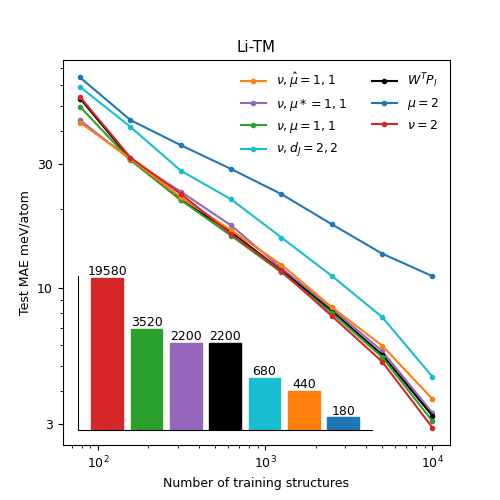

In [8]:
error_key = "per_atom_test_MAE"
Energy_unit = "meV/atom"
Econv = 1000
Nmin = 65

i = 0
data = all_kfold["Li-TM"]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

bar_labels = []
for name, d1 in data.items():
    zetas = list(d1.keys())
    for zeta, d2 in d1.items():
        
        #only draw selected lines
        if zeta<7.5:
            continue
        if name not in bar_labels:
            bar_labels.append(name)
        
        label=name2label(name)
        ls = "-"
        
        #plotting
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: x[0])
        pdata = np.array(pdata)
        ax.plot(pdata[:,0], Econv*pdata[:,1], label=label, c=cdic[name], ls=ls, marker="o", markersize=3)
        
#set the axes scales
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of training structures")
ylabel = "Test "
for x in ["MAE", "RMSE"]:
    if x in error_key:
        ylabel += x
ax.set_ylabel(ylabel + " "+Energy_unit)
ax.legend(ncol=2)
ax.set_title("Li-TM")

ys = [ 3, 10, 30]
ax.set_yticks(ys)
ax.set_yticklabels([str(y) for y in ys])

#adjust the legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key = lambda t: (-len(t[0]), t[0])))
ax.legend(handles, labels, ncol=2, frameon=False, loc="upper right")

if False:
    #add in the zeta subplot
    gs = fig.add_gridspec(50, 50)
    ax3 = fig.add_subplot(gs[28:45, 5:32])

    for name, d1 in data.items():
        zeta_data = []
        for zeta, d2 in d1.items():
            pdata = d2[["N_train", error_key]]
            pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
            pdata = sorted(pdata, key = lambda x: -x[0])
            big = pdata[0]
            zeta_data.append([zeta, big[1], big[2]])
        zeta_data = sorted(zeta_data, key = lambda x: x[0])
        zeta_data = np.array(zeta_data)
        print(name, zeta_data)
        ax3.plot(zeta_data[:,0], Econv*zeta_data[:,1], marker="x", label=label, c=cdic[name], ls=ls, markersize=3)

    ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)
    ax3.set_facecolor((1,1,1,0))
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.yaxis.set_ticklabels([])

    xs = [1, 2, 4, 8]
    ax3.set_xticks(xs)
    ax3.set_xticklabels([str(x) for x in xs])
else:
    #add the bar chart
    N = 8
    L = 4
    S = 11
    gs = fig.add_gridspec(50, 50)
    ax3 = fig.add_subplot(gs[28:48, 2:40])
    all_bar_values = [get_len(name, N, L, S) for name in bar_labels]
    bar_values = [x[0] for x in all_bar_values]
    bar_labels, bar_values = zip(*sorted(zip(bar_labels, bar_values), key = lambda x: -x[1]))

    barlist = ax3.bar([name2label(name) for name in bar_labels], bar_values)
    for i, lab in enumerate(bar_labels):
        barlist[i].set_color(cdic[lab])


    ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)
    ax3.set_facecolor((1,1,1,0))
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_ylim([120,None])
    ax3.set_yscale("log")
    ax3.yaxis.set_ticklabels([])

    ind = 0
    for label, val in zip(bar_labels, bar_values):
        ax3.text(ind, val*1.1, str(int(val)), ha="center")
        ind += 1

plt.savefig("Plots/Li-TM.pdf")

# Elpasolites

<IPython.core.display.Javascript object>


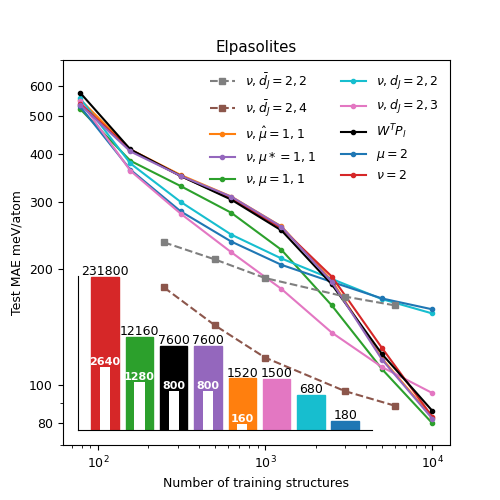

In [10]:
MC_dJ_data = []
with open("data/MC_dJ_4_2.txt", "r") as f:
    for line in f:
        ls = line.split(",")
        MC_dJ_data.append([float(x) for x in ls])
MC_dJ_data = np.array(MC_dJ_data)

error_key = "per_atom_test_MAE"
Energy_unit = "meV/atom"
Econv = 1000
Nmin = 40

i = 0
data = all_kfold["elpasolites"]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

bar_labels = []
for name, d1 in data.items():
    for zeta, d2 in d1.items():
        #only draw selected lines
        if zeta != 1:
            continue
        if name not in bar_labels:
            bar_labels.append(name)
        
        label=name2label(name)
        ls = "-"
        
        #plotting
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: x[0])
        pdata = np.array(pdata)
        ax.plot(pdata[:,0], Econv*pdata[:,1], label=label, c=cdic[name], ls=ls, marker="o", markersize=3)
        
#plot previous models
ax.plot(MC_dJ_data[:,0], MC_dJ_data[:,1], label=r"$\nu,\bar{d_J}=2,4$", marker="s", ls="--", c="C5", markersize=4)
ax.plot(MC_dJ_data[:,0], MC_dJ_data[:,2], label=r"$\nu,\bar{d_J}=2,2$", marker="s", ls="--", c="C7", markersize=4)
        
#set the axes scales
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of training structures")
ylabel = "Test "
for x in ["MAE", "RMSE"]:
    if x in error_key:
        ylabel += x
ax.set_ylabel(ylabel + " "+Energy_unit)
ax.legend(ncol=2)
ax.set_title("Elpasolites")

#adjust the legend
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key = lambda t: (-len(t[0]), t[0])))
ax.legend(handles, labels, ncol=2, frameon=False, loc="upper right")

ax.set_yticks([])
ys = [80, 100, 200,300, 400, 500, 600]
ax.set_yticks(ys)
ax.set_yticklabels([str(y) for y in ys], minor=False)
ax.set_ylim([70, 700])

#add the bar chart
N = 8
L = 4
S = 38
gs = fig.add_gridspec(50, 50)
ax3 = fig.add_subplot(gs[28:48, 2:40])
all_bar_values = [get_len(name, N, L, S, S2=4) for name in bar_labels]
bar_values = [x[0] for x in all_bar_values]
values_2 = [x[1] for x in all_bar_values]

bar_labels, bar_values, values_2 = zip(*sorted(zip(bar_labels, bar_values, values_2), key = lambda x: -x[1]))

barlist = ax3.bar([name2label(name) for name in bar_labels], bar_values)
for i, lab in enumerate(bar_labels):
    barlist[i].set_color(cdic[lab])
barlist_2 = ax3.bar([name2label(name) for name in bar_labels], values_2, color="white", width=0.3)


ax3.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False)
ax3.set_facecolor((1,1,1,0))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_ylim([120,None])
ax3.set_yscale("log")
ax3.yaxis.set_ticklabels([])

ind = 0
for label, val in zip(bar_labels, bar_values):
    ax3.text(ind, val*1.1, str(int(val)), ha="center")
    val2 =values_2[ind]
    if val2 > 0:
        ax3.text(ind, val2*1.1, str(int(val2)), ha="center", color="white", weight="bold", fontsize=8)
    ind += 1

plt.savefig("Plots/Elpasolites.pdf")

# 2 Energy fits using Atomic Centered Symmetry Functions

# QM9-ACSF

<IPython.core.display.Javascript object>


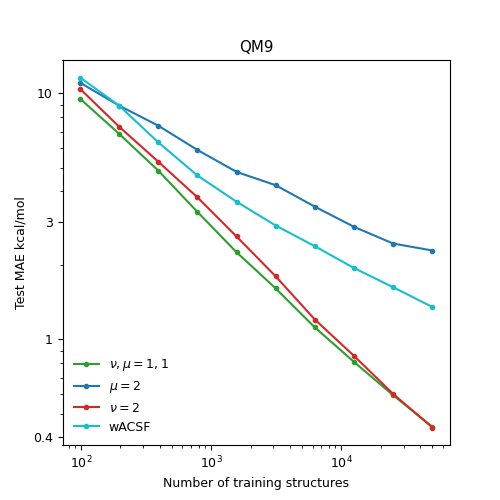

In [11]:
error_key = "total_test_MAE"
Energy_unit = "kcal/mol"
Econv = 627.5
Nmin = 90

i = 0
data = all_kfold["QM9_ACSF"]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

bar_labels = []
for name, d1 in data.items():
    for zeta, d2 in d1.items():
        #only draw selected lines
        if zeta != 2:
            continue
        if name not in bar_labels:
            bar_labels.append(name)
        
        label=name2label(name)
        if zeta > 1.5:
            ls = "-"
        else:
            ls = "--"
            label = None
        
        #plotting
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: x[0])
        pdata = np.array(pdata)
        ax.plot(pdata[:,0], Econv*pdata[:,1], label=label, c=cdic[name], ls=ls, marker="o", markersize=3)
        
#set the axes scales
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of training structures")
ylabel = "Test "
for x in ["MAE", "RMSE"]:
    if x in error_key:
        ylabel += x
ax.set_ylabel(ylabel + " "+Energy_unit)
ax.legend(ncol=1, loc="lower left")
ax.set_title("QM9")

ys = [0.4, 1, 3, 10]
ax.set_yticks(ys)
ax.set_yticklabels([str(y) for y in ys])


#adjust the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for l in labels:
    if "d_J" in l:
        l = "wACSF"
    new_labels.append(l)
labels, handles = zip(*sorted(zip(new_labels, handles), key = lambda t: (-len(t[0]), t[0])))
ax.legend(handles, labels, ncol=1, frameon=False, loc="lower left")

plt.savefig("Plots/QM9_ACSF.pdf")

<IPython.core.display.Javascript object>


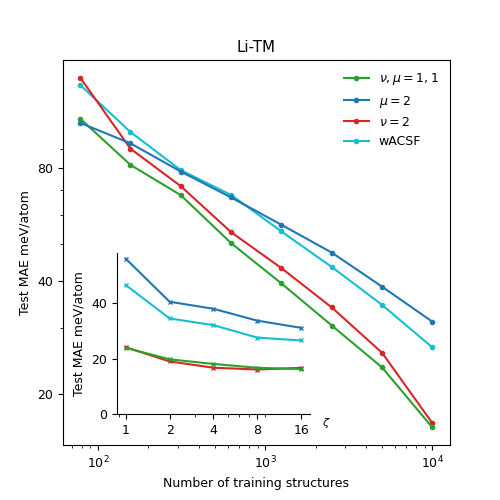

In [12]:
error_key = "per_atom_test_MAE"
Energy_unit = "meV/atom"
Econv = 1000
Nmin = 65

i = 0
data = all_kfold["Li-TM_ACSF"]
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

bar_labels = []
for name, d1 in data.items():
    zetas = list(d1.keys())
    for zeta, d2 in d1.items():
        
        #only draw selected lines
        if zeta != 16:
            continue
        if name not in bar_labels:
            bar_labels.append(name)
        
        label=name2label(name)
        ls = "-"
        
        #plotting
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: x[0])
        pdata = np.array(pdata)
        ax.plot(pdata[:,0], Econv*pdata[:,1], label=label, c=cdic[name], ls=ls, marker="o", markersize=3)
        
#set the axes scales
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of training structures")
ylabel = "Test "
for x in ["MAE", "RMSE"]:
    if x in error_key:
        ylabel += x
ax.set_ylabel(ylabel + " "+Energy_unit)
ax.legend(ncol=2)
ax.set_title("Li-TM")

ys = [ 20, 40, 80]
ax.set_yticks(ys)
ax.set_yticklabels([str(y) for y in ys])

#adjust the legend
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for l in labels:
    if "d_J" in l:
        l = "wACSF"
    new_labels.append(l)
labels, handles = zip(*sorted(zip(new_labels, handles), key = lambda t: (-len(t[0]), t[0])))
ax.legend(handles, labels, ncol=1, frameon=False, loc="upper right")


#add in the zeta subplot
gs = fig.add_gridspec(50, 50)
ax3 = fig.add_subplot(gs[25:46, 7:32])

for name, d1 in data.items():
    zeta_data = []
    for zeta, d2 in d1.items():
        pdata = d2[["N_train", error_key]]
        pdata = [[x[0], x[1][0], x[1][1]] for x in pdata.values if x[0] > Nmin]
        pdata = sorted(pdata, key = lambda x: -x[0])
        big = pdata[0]
        zeta_data.append([zeta, big[1], big[2]])
    zeta_data = sorted(zeta_data, key = lambda x: x[0])
    zeta_data = np.array(zeta_data)
    ax3.plot(zeta_data[:,0], Econv*zeta_data[:,1], marker="x", label=label, c=cdic[name], ls=ls, markersize=3)


ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_facecolor([1,1,1,0])
ys = [ 20, 30, 40, 50,  60]
ax3.set_xscale("log")
ax3.set_ylim([0, None])
xs = [1, 2, 4, 8, 16]
ax3.set_xticks(xs)
ax3.set_xticklabels([str(x) for x in xs])
ax.text(2200, 16.4, r"$\zeta$", fontsize=8)
ax3.set_ylabel(ylabel + " "+Energy_unit)
    
plt.savefig("Plots/Li-TM_ACSF.pdf")

# Fit to High Entropy Alloy dataset using gapfit
### KRR model trained on Energies, Forces and Virials

In [13]:
#read in json file with results of all models
with open("data/all_errors.json", "r") as f:
    all_error_string = f.read()
all_errors = json.loads(all_error_string)
print(all_errors.keys())

dict_keys(['distance_2b+1001', 'distance_2b+1010', 'distance_2b+2000', 'HEA_2b_ns', 'distance_2b', 'distance_2b+3b'])


<IPython.core.display.Javascript object>


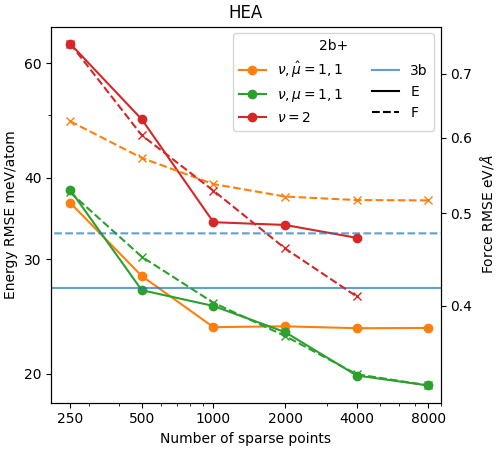

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [14]:

def acsf_name2label(name):
    if "2000" in name:
        return r"$\nu=2$"
    elif "1010" in name:
        return r"$\nu,\mu=1,1$"
    elif "1001" in name:
        return r"$\nu,\hat{\mu}=1,1$"
    elif "3b" in name:
        return "3b"
    else:
        return False


def plot_config_errors(all_errors, config, ax2):

    ax = ax2.twinx()
    names = all_errors.keys()
    #names = [x for x in names if "HEA" not in x and x != "distance_2b"]

    for i, name in enumerate(names):
        if acsf_name2label(name) in [False, "3b"]:
            continue
        c = "C"+str(i+1)
        
        pd = []
        dic = all_errors[name]
        for ns, d in dic.items():
            E_RMSE = d["Es"][config]
            pd.append([int(ns), float(E_RMSE)])
        pd = sorted(pd, key = lambda x: x[0])
        pd = np.array(pd)
        label = acsf_name2label(name)
        ax2.plot(pd[:,0], 1000*pd[:,1], label=label, marker="o", c=c)
        
        
       

        pd = []
        dic = all_errors[name]
        for ns, d in dic.items():
            E_RMSE = d["Fs"][config]
            pd.append([int(ns), float(E_RMSE)])
        pd = sorted(pd, key = lambda x: x[0])
        pd = np.array(pd)
        ax.plot(pd[:,0], pd[:,1], label=label, marker="x", ls="--", c=c)
        
    
    ax2.set_xlabel("Number of sparse points")
    ax.set_ylabel(r"Force RMSE eV/$\AA$")
    ax2.set_ylabel("Energy RMSE meV/atom")
    
    
    if config == "all" and True:
        ax2.plot([0, 10000], [27.1, 27.1], label="3b", c="C0", alpha =0.7)    
        ax.plot([0, 10000], [0.48, 0.47647], label="3b", c="C0", ls="--", alpha=0.7) 
        

    handles, labels = ax2.get_legend_handles_labels()
    line = plt.Line2D([0], [0], label="E", color='k')
    line2 = plt.Line2D([0], [0], label="F", color='k', ls="--")
    handles.append(line)
    labels.append("E")

    handles.append(line2)
    labels.append("F")
    
    for a in [ax, ax2]:
        a.set_xscale("log")
        a.set_yscale("log")
        a.set_xlim([None, 9000])

        xs = [250, 500, 1000, 2000, 4000, 8000]
        a.set_xticks(xs)
        a.set_xticklabels([str(x) for x in xs])
        
    ys = [20, 30, 40, 60]
    ax2.set_yticks(ys)
    ax2.set_yticklabels([str(y) for y in ys])
    
    ys = [0.4, 0.5, 0.6, 0.7]
    ax.set_yticks(ys)
    ax.set_yticklabels([str(y) for y in ys])

    s = r"2b + $\nu$, $\hat{\nu}$, $\mu$, $\hat{\mu}$              "
    ax2.legend( handles, labels, ncol=2, title="2b+")
    
    


c_types = ["all"]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

fig, axes = plt.subplots(figsize=(5, 4.5), ncols=1, nrows=1, constrained_layout=True)
axes = [[axes]]

i = 0
for row_ax in axes:
    for cax in row_ax:
        if i < len(c_types):
            config = c_types[i]
            plot_config_errors(all_errors, config, cax)
        i += 1

axes[0][0].set_title("HEA")
    
fig.savefig("Plots/HEA_nsparse.pdf")

<IPython.core.display.Javascript object>


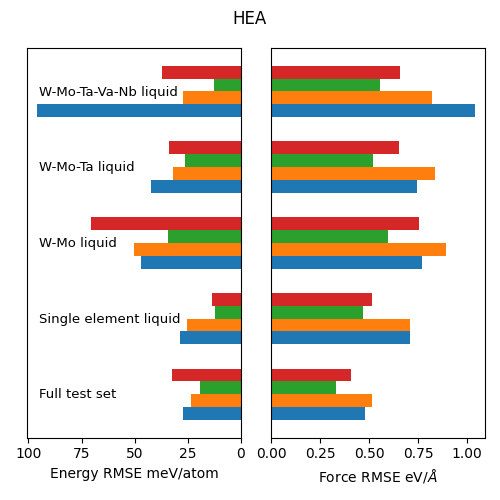

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [15]:
cs = ["all", 'liquid', 'W-Mo_liquid', 'W-Mo-Ta_liquid',  'hea_liquid']
names = ['distance_2b+3b', 'distance_2b+1001', 'distance_2b+1010', 'distance_2b+2000']

fig = plt.figure(figsize=(5, 5))
axes = [fig.add_subplot(1,2,i) for i in [1,2]]

for ax, k in zip(axes, ["Es", "Fs"]):
    es = {}
    for name in names:
        es[name] = []
        d = all_errors[name]
        Ns = sorted(d.keys(), key = lambda x: -int(x))
        d = d[Ns[0]]
        for c in cs:
            val = d[k][c]
            #convert to meV/atom
            if k == "Es":
                val *= 1000
            es[name].append(val)
    #pp.pprint(es)       
    w = 0.17
    ind = np.arange(len(cs)) 
    for i, name in enumerate(names):
        ax.barh(ind+i*w, es[name], w)
  
    if k == "Es":
        ax.set_xlabel("Energy RMSE meV/atom")
    else:
        ax.set_xlabel(r"Force RMSE eV/$\AA$")

axes[0].invert_xaxis()
axes[0].set_yticks([-5])
axes[1].set_yticks([-5])

axes[0].text(95, 0.2, "Full test set", fontsize=9.5)
axes[0].text(95, 1.2, r"Single element liquid", fontsize=9.5)
axes[0].text(95, 2.2, r"W-Mo liquid", fontsize=9.5)
axes[0].text(95, 3.2, r"W-Mo-Ta liquid", fontsize=9.5)
axes[0].text(95, 4.2, r"W-Mo-Ta-Va-Nb liquid", fontsize=9.5)



fig.suptitle("HEA")
plt.tight_layout()
fig.savefig("Plots/HEA_errors.pdf")


# Information Imbalance

In [16]:
fnames = []
fnames += ["data/amino_acids_45891_cw=0.0_rcut=5.0_ranks.json"]
fnames += ["data/three_comp_liquid_22272_cw=0.0_rcut=5_ranks.json"]

rank_data = {}
for fn, dname in zip(fnames, ["Amino Acids", "HEA liquid"]):
    with open(fn, "r") as f:
        data_string = f.read()
    rank_dic = json.loads(data_string)
    rank_data[dname] = rank_dic


# Amino Acids

<IPython.core.display.Javascript object>


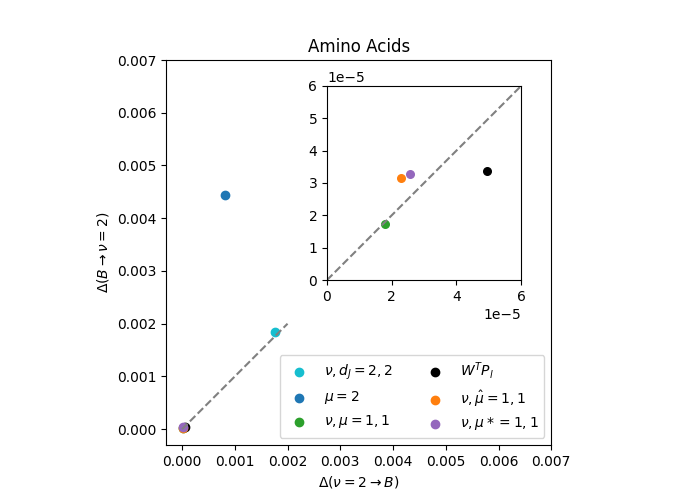

In [17]:
dname = "Amino Acids"
rank_dic = rank_data[dname]
deltas = {}

#compute the informatino imbalance
for alpha, rd in rank_dic.items():
    deltas[alpha] = {}
    for beta, ranks in rd.items():
        delta = 2*np.mean(ranks)/len(ranks)
        deltas[alpha][beta] = delta

#setup the figure axes
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

alphas = list(deltas.keys())
gs = fig.add_gridspec(50, 50)
ax3 = fig.add_subplot(gs[2:30, 22:40])

A = "Species_F"
data = []
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(alphas):
        #sort out names and labels
        s = alpha.split(":")[0]
        dc, c = s.split("_")
        alpha_name = compress2name(dc, c)
        alpha_label = name2label(alpha_name)
        s = beta.split(":")[0]
        dc, c = s.split("_")
        beta_name = compress2name(dc, c)
        beta_label = name2label(beta_name)
        
        #skip if required
        if (A not in alpha) or i == j:
            continue

        #do the plotting
        y = deltas[alpha][beta]
        x = deltas[beta][alpha]
        ax.scatter(y, x, marker="o", label=beta_label, c=cdic[beta_name])
        data += [y,x]
            
        #add to inset
        if x**2+y**2 < 0.1 or True:
            ax3.scatter(y, x, marker="o", label= beta_label, s=30, zorder=1, c=cdic[beta_name]) 


#main plot limits
ax.plot([0,0.002], [0,0.002], ls="--", c="grey")
ax.set_xlim([-0.0003, 0.007 ])
ax.set_ylim([-0.0003, 0.007])
ax.set_aspect("equal")


#inset plot limits
ax3.set_aspect("equal")
mx = 6e-5
ax3.set_xlim([0, mx])
ax3.set_ylim([0,mx])
ax3.plot([0,mx], [0,mx], ls="--", c="grey")

#labels and legends
ax.set_xlabel(r"$\Delta(\nu=2 \rightarrow B)$")
ax.set_ylabel(r"$\Delta(B \rightarrow \nu=2)$")
#ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.7 ),ncol=1, fancybox=False, shadow=False, title="B")
ax.legend(loc="lower right",ncol=2, title=None, frameon=True)
ax.set_title(dname)

plt.savefig("Plots/Amino_acids_II.pdf")

# HEA

<IPython.core.display.Javascript object>


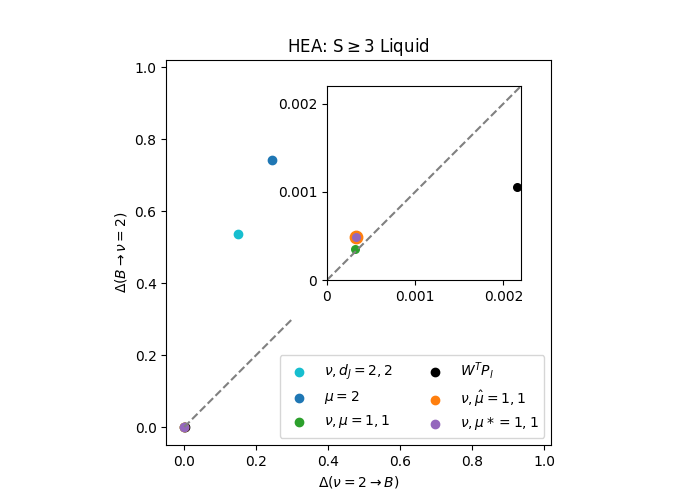

In [18]:
dname = "HEA liquid"
rank_dic = rank_data[dname]
deltas = {}

#compute the informatino imbalance
for alpha, rd in rank_dic.items():
    deltas[alpha] = {}
    for beta, ranks in rd.items():
        delta = 2*np.mean(ranks)/len(ranks)
        deltas[alpha][beta] = delta

#setup the figure axes
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

alphas = list(deltas.keys())
gs = fig.add_gridspec(50, 50)
ax3 = fig.add_subplot(gs[2:30, 22:40])

A = "Species_F"
data = []
for i, alpha in enumerate(alphas):
    for j, beta in enumerate(alphas):
        #sort out names and labels
        s = alpha.split(":")[0]
        dc, c = s.split("_")
        alpha_name = compress2name(dc, c)
        alpha_label = name2label(alpha_name)
        s = beta.split(":")[0]
        dc, c = s.split("_")
        beta_name = compress2name(dc, c)
        beta_label = name2label(beta_name)
        
        #skip if required
        if (A not in alpha) or i == j:
            continue

        #do the plotting
        y = deltas[alpha][beta]
        x = deltas[beta][alpha]
        ax.scatter(y, x, marker="o", label=beta_label, c=cdic[beta_name])
        data += [y,x]
            
        #add to inset
        if x**2+y**2 < 0.1 or True:
            if "hat" in beta_label:
                ax3.scatter(y, x, marker="o", label= beta_label, s=80, zorder=1, c=cdic[beta_name]) 
            else:
                ax3.scatter(y, x, marker="o", label= beta_label, s=30, zorder=2, c=cdic[beta_name]) 


#main plot limits
ax.plot([0,0.3], [0,0.3], ls="--", c="grey")
ax.set_xlim([-0.05, 1.02 ])
ax.set_ylim([-0.05, 1.02])
ax.set_aspect("equal")


#inset plot limits
ax3.set_aspect("equal")
mx = 0.0022
ax3.set_xlim([0, mx])
ax3.set_ylim([0,mx])
ax3.plot([0,mx], [0,mx], ls="--", c="grey")

xticks = [0, 0.001, 0.002]
ax3.set_xticks(xticks)
ax3.set_xticklabels([str(x) for x in xticks])
ax3.set_yticks(xticks)
ax3.set_yticklabels([str(x) for x in xticks])

#labels and legends
ax.set_xlabel(r"$\Delta(\nu=2 \rightarrow B)$")
ax.set_ylabel(r"$\Delta(B \rightarrow \nu=2)$")
#ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.7 ),ncol=1, fancybox=False, shadow=False, title="B")
ax.legend(loc="lower right",ncol=2, title=None, frameon=True)
ax.set_title(r"HEA: S$\geq$3 Liquid")
#plt.tight_layout()
plt.savefig("Plots/HEA_liquid_II.pdf")

# Distance-distance correlation plots

In [19]:
def load_hist(fname):
    with open(fname, "r") as f:
        data_string = f.read()
    hist_dic = json.loads(data_string)
    return hist_dic

fname = "data/three_comp_liquid_22272_cw=0.0_rcut=5"
rank_dic = load_hist(fname+"_rank-hist.json")
dist_dic = load_hist(fname+"_dist-hist.json")

names = set()
for key, d in rank_dic.items():
    names.add(key)
    for nam in d:
        names.add(nam)

<IPython.core.display.Javascript object>


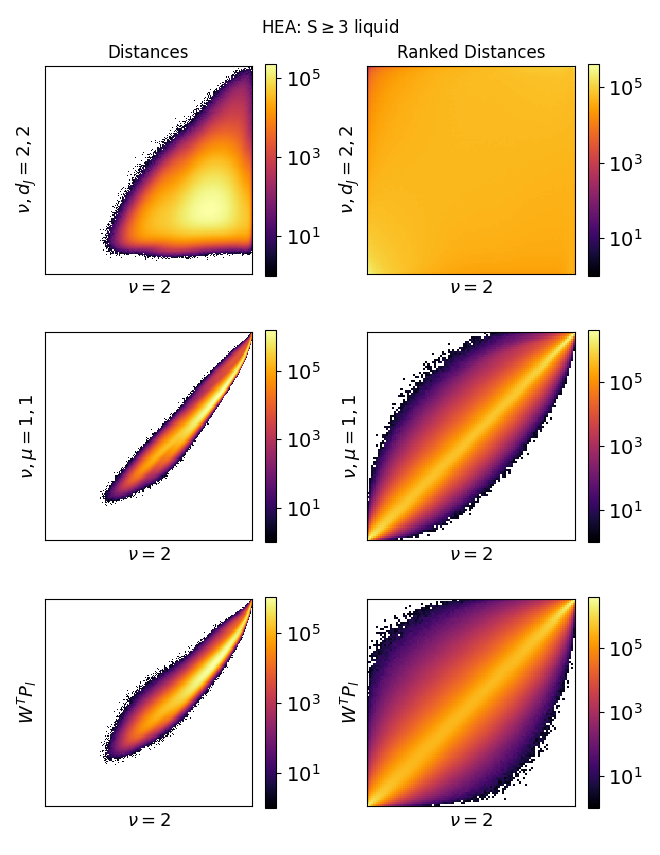

<ipython-input-20-55e3e036bb0e>:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values, bins = np.array(hist_dic[name2][name1])
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [20]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import LogNorm

#cmap where 0 is white
inferno = cm.get_cmap("inferno", 1280)
pos_colors = inferno(np.linspace(0,1,1280))
custom = ListedColormap([[1,1,1]]+list(pos_colors))

def n2l(name):
    s = name.split(":")[0]
    dc, c = s.split("_")
    nam = compress2name(dc, c)
    label = name2label(nam)
    return nam, label

def plot_dists(name1, name2, values, bins, ax):
    extent = [min(bins[0]), max(bins[0]), min(bins[1]), max(bins[1])]
    bins = np.array(bins)
    im = ax.pcolormesh(bins[0]/max(bins[0]), bins[1]/max(bins[1]), values, cmap=custom, norm=LogNorm(vmin=0.99), shading="flat")

    nam1, lab1 = n2l(name1)
    nam2, lab2 = n2l(name2)
    ax.set_xlabel(lab1, size=13)
    ax.set_ylabel(lab2, size=13)
    ax.set_xlim([0,None])
    ax.set_ylim([0,None])
    ax.set_aspect("equal")
    return im

#setup figure and subplot axes
N = len(names) 
cols = 2
rows = 3
size =3
width = size*cols
height = size*rows*0.95
fig = plt.figure(figsize=(width*1.1, height))
axes = [fig.add_subplot(rows, cols, i+1) for i in range(0,6)]

name1 = "Species_F: n=12 l=9"

others = [ 'Any_F: n=12 l=9', 'Any+Ising_F: n=12 l=9', 'Species_SPHERE: n=12 l=9', 'Species_REBIN: n=12 l=9', 'Species_ANY: n=12 l=9', 'Species_RC: n=12 l=9' ]
others = [  'Any+Ising_F: n=12 l=9', 'Species_ANY: n=12 l=9', 'Species_RC: n=12 l=9' ]
N = len(others)
for q, hist_dic in enumerate([dist_dic, rank_dic]):
    for j, name2 in enumerate(others):
        ax_ind = j*2+q #all dists then all ranks
        ax = axes[ax_ind]

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)

        if name1 in hist_dic and name2 in hist_dic[name1]:
            values, bins = hist_dic[name1][name2]
            values = np.array(values)
            values = values.T
        else:
            values, bins = np.array(hist_dic[name2][name1])
            values = np.array(values)
            bins = [bins[1], bins[0]]
            
        im = plot_dists(name1, name2, values, bins, ax)
        cbar = fig.colorbar(im, ax=ax, shrink=0.9)
        cbar.ax.tick_params(labelsize=14)

title = dataset_name + "\nDistance-Distance Histograms\n\nRank-Rank Histograms\n\n"
fig.suptitle(r"HEA: S$\geq3$ liquid")
plt.tight_layout()



axes[0].set_title("Distances")
axes[1].set_title("Ranked Distances")
fig.savefig("Plots/correlation_HEA_liquid_subset.png", dpi=600)

<IPython.core.display.Javascript object>


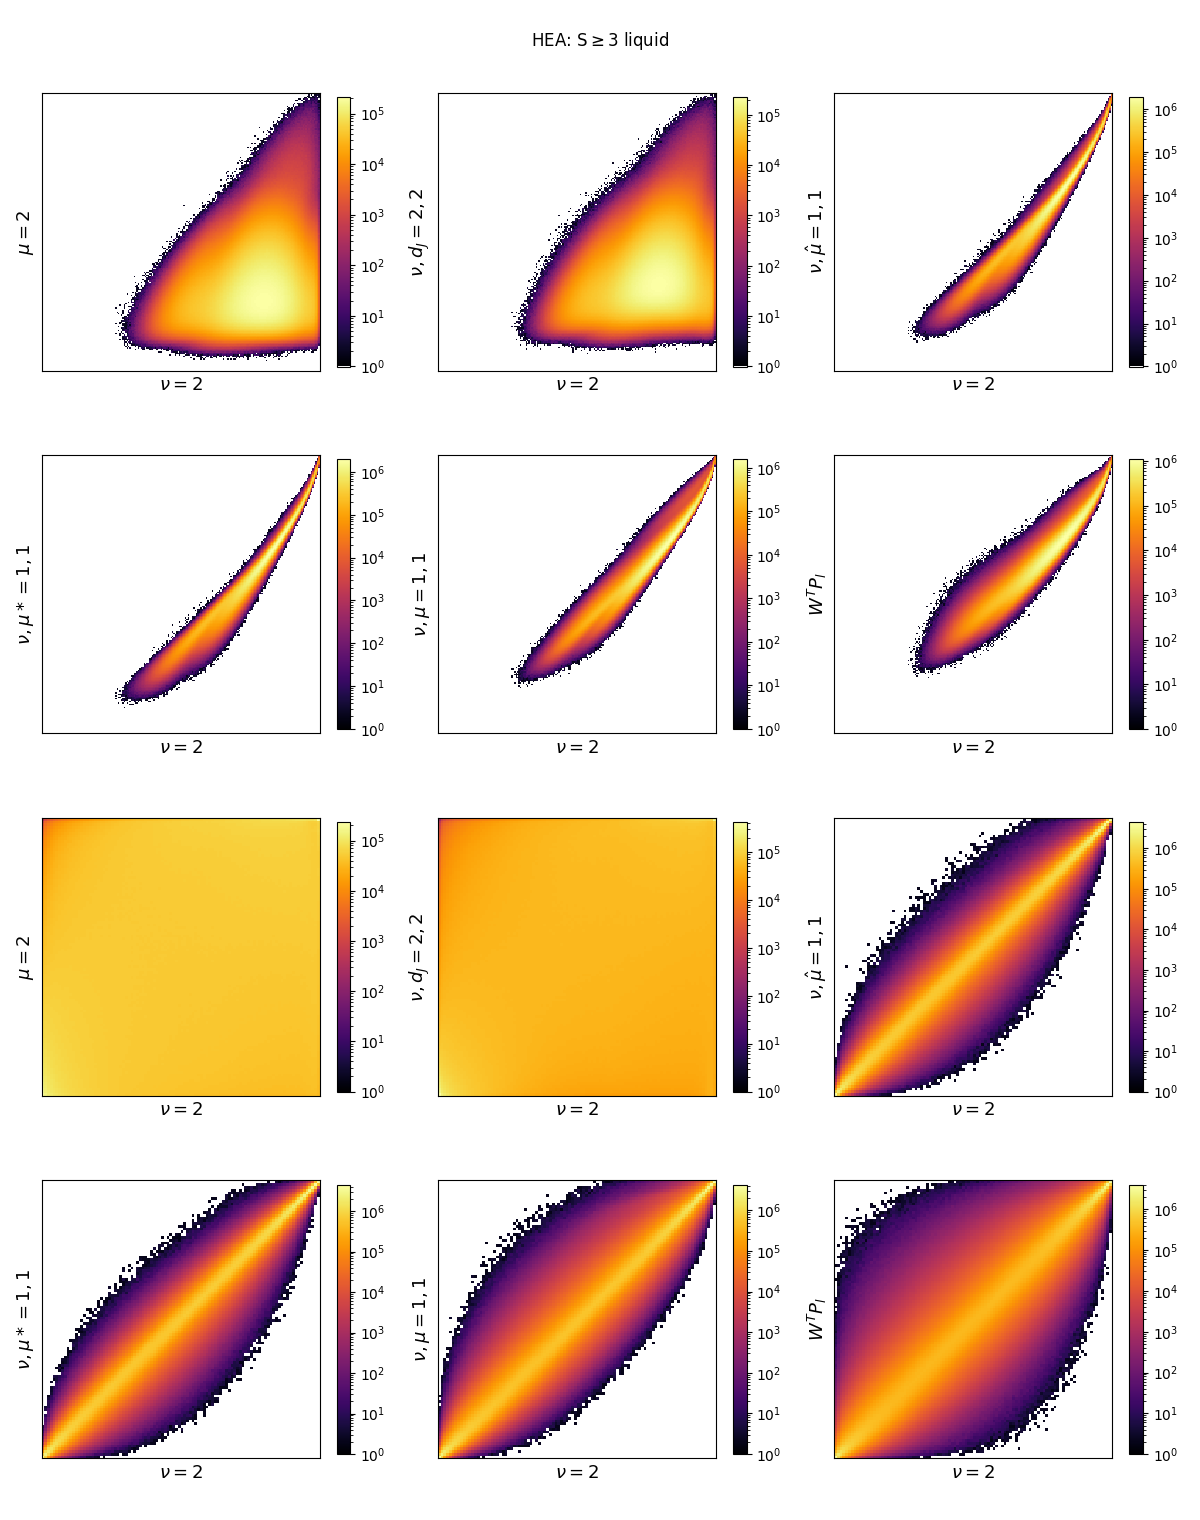

<ipython-input-21-3c81410fe02a>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values, bins = np.array(hist_dic[name2][name1])


In [21]:
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import LogNorm

#cmap where 0 is white
inferno = cm.get_cmap("inferno", 1280)
pos_colors = inferno(np.linspace(0,1,1280))
custom = ListedColormap([[1,1,1]]+list(pos_colors))

def n2l(name):
    s = name.split(":")[0]
    dc, c = s.split("_")
    nam = compress2name(dc, c)
    label = name2label(nam)
    return nam, label

def plot_dists(name1, name2, values, bins, ax):
    extent = [min(bins[0]), max(bins[0]), min(bins[1]), max(bins[1])]
    bins = np.array(bins)
    im = ax.pcolormesh(bins[0]/max(bins[0]), bins[1]/max(bins[1]), values, cmap=custom, norm=LogNorm(vmin=0.99), shading="flat")

    nam1, lab1 = n2l(name1)
    nam2, lab2 = n2l(name2)
    ax.set_xlabel(lab1, size=13)
    ax.set_ylabel(lab2, size=13)
    ax.set_xlim([0,None])
    ax.set_ylim([0,None])
    ax.set_aspect("equal")
    return im

#setup figure and subplot axes
N = len(names) 
cols = 3
rows = int(2*(N-1)/cols)
size =4
width = size*cols
height = size*rows*0.95
fig = plt.figure(figsize=(width, height))
axes = [fig.add_subplot(rows, cols, i+1) for i in range(0,2*(N-1))]

name1 = "Species_F: n=12 l=9"

others = [ 'Any_F: n=12 l=9', 'Any+Ising_F: n=12 l=9', 'Species_SPHERE: n=12 l=9', 'Species_REBIN: n=12 l=9', 'Species_ANY: n=12 l=9', 'Species_RC: n=12 l=9' ]
N = len(others)
for q, hist_dic in enumerate([dist_dic, rank_dic]):
    for j, name2 in enumerate(others):
        ax_ind = q*N+j #all dists then all ranks
        ax = axes[ax_ind]

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)

        if name1 in hist_dic and name2 in hist_dic[name1]:
            values, bins = hist_dic[name1][name2]
            values = np.array(values)
            values = values.T
        else:
            values, bins = np.array(hist_dic[name2][name1])
            values = np.array(values)
            bins = [bins[1], bins[0]]
            
        im = plot_dists(name1, name2, values, bins, ax)
        fig.colorbar(im, ax=ax, shrink=0.75)

title = dataset_name + "\nDistance-Distance Histograms\n\nRank-Rank Histograms\n\n"
fig.suptitle(r"HEA: S$\geq3$ liquid")
plt.tight_layout()

fig.savefig("Plots/correlation_HEA_liquid.png", dpi=600)

# Sensitivity Analysis

In [22]:
fname = "data/sensitivity_three_comp_liquid_1005.json"
with open(fname, "r") as f:
    data_string = f.read()
eig_dic = json.loads(data_string)

<IPython.core.display.Javascript object>


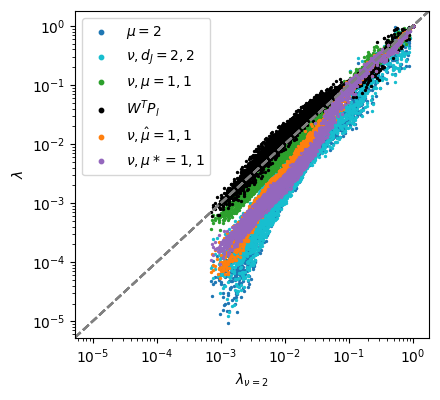

In [23]:
#setup figure and subplots
N = 1
rows = 1
cols = 1
size = 4
width = cols*size*1.1
height = rows*size
fig = plt.figure(figsize=((width, height)))
axes = [fig.add_subplot(rows, cols, i,) for i in range(1, 2)]



base_name = "Species_F: n=12 l=9"
_, base_label = n2l(base_name)
min_eig_num = 6
min_val = 1e-15
#Have minimum of 6 zero eigenvalues. Don't plot them.
#Scale eigenvalues so that largest is always 1
base_eigs = np.array([x/max(y) for y in eig_dic[base_name] for x in y[min_eig_num:]])

ax_ind = 0
for nam, eig_list in eig_dic.items():
    if nam == base_name or nam == "Gram":
        continue
    
    name, label = n2l(nam)
    eigs = np.array([x/max(y) for y in eig_list for x in y[min_eig_num:]])
    ax = axes[ax_ind%1]
    ax.scatter(base_eigs, eigs, s=2, c=cdic[name], label=label)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"$\lambda_{\nu=2}$")
    ax.set_ylabel(r"$\lambda$")
  
    #axis limits
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims+ylims), max(xlims+ylims)]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, ls="--", c="grey")
    ax_ind += 1

lgnd = ax.legend()
for x in lgnd.legendHandles:
    x._sizes = [10]
plt.tight_layout(pad=0.8)
fig.savefig("Plots/eig_scatter_HEA_liquid_combined.png", dpi=900)


<IPython.core.display.Javascript object>


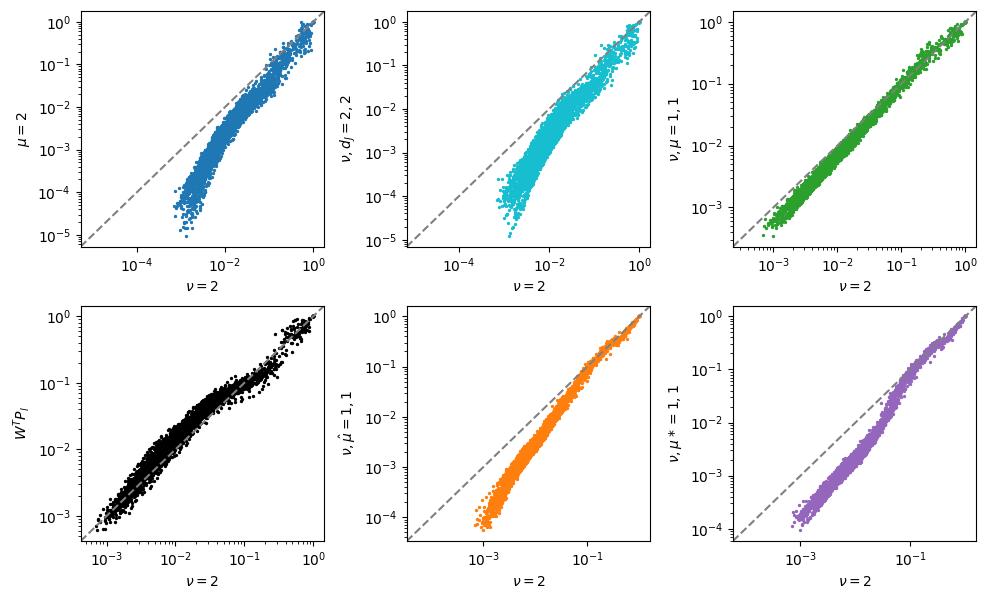

In [24]:
#setup figure and subplots
N = len(eig_dic)
rows = 2
cols = int(np.ceil((N-2)/rows))
size = 3
width = cols*size*1.1
height = rows*size
fig = plt.figure(figsize=((width, height)))
axes = [fig.add_subplot(rows, cols, i,) for i in range(1, N-1)]



base_name = "Species_F: n=12 l=9"
_, base_label = n2l(base_name)
min_eig_num = 6
min_val = 1e-15
#Have minimum of 6 zero eigenvalues. Don't plot them.
#Scale eigenvalues so that largest is always 1
base_eigs = np.array([x/max(y) for y in eig_dic[base_name] for x in y[min_eig_num:]])

ax_ind = 0
for nam, eig_list in eig_dic.items():
    if nam == base_name or nam == "Gram":
        continue
    
    name, label = n2l(nam)
    eigs = np.array([x/max(y) for y in eig_list for x in y[min_eig_num:]])
    ax = axes[ax_ind]
    ax.scatter(base_eigs, eigs, s=2, c=cdic[name])
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(base_label)
    ax.set_ylabel(label)
  
    #axis limits
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    lims = [min(xlims+ylims), max(xlims+ylims)]
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, ls="--", c="grey")
    ax_ind += 1
    #ax.legend()

plt.tight_layout(pad=0.8)
fig.savefig("Plots/eig_scatter_HEA_liquid.png", dpi=900)


# Ordrered Eigenavlues

<IPython.core.display.Javascript object>


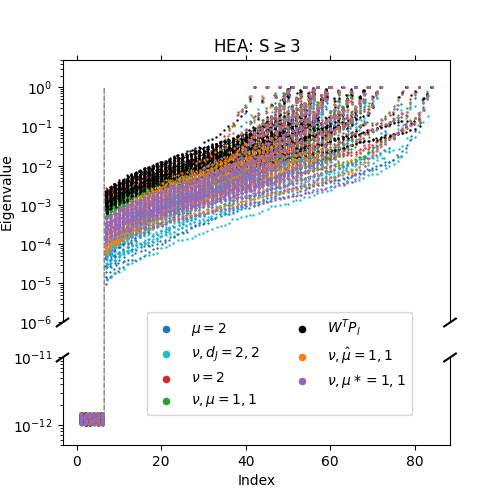

In [25]:
from matplotlib.patches import ConnectionPatch

min_val = 1e-12

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,5), gridspec_kw={'height_ratios': [3, 1]})

for key, item in eig_dic.items():
    if "Gram" in key:
        continue
    name, label = n2l(key)    
    
    #add small amount of random noise to x and y coords to make data more visible
    pdata = []
    for eigs in item:
        for i, e in enumerate(eigs):
            pdata.append([i+1-0.2+0.4*np.random.uniform(), max([min_val+0.5*min_val*np.random.uniform(), e/max(eigs)])])
    pdata = np.array(pdata)      
            
    ax.scatter(pdata[:,0], pdata[:,1], label=label, s=0.5, c=cdic[name])
    ax2.scatter(pdata[:,0], pdata[:,1], label=label, s=0.2, c=cdic[name])

#set axes limits, labels, scales etc.
for bax in [ax, ax2]:
    bax.set_yscale("log")
    bax.vlines(6.5, min_val/10, 1e1, ls="--", color="None")
    
ax.set_ylim([1e-6, 5])
ax2.set_ylim([1e-12*0.5, 1e-11])

lgd = ax2.legend(ncol=2, bbox_to_anchor=(0.2, 1.6))
for  x in lgd.legendHandles:
    x._sizes = [20]

ax.set_ylabel("Eigenvalue")
ax2.set_xlabel("Index")
xlims = ax.get_xlim()
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


#draw the axis break
d = .015  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - 3*d, 1 + 3*d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - 3*d, 1 + 3*d), **kwargs)  # bottom-right diagonal

con = ConnectionPatch(xyA=[6.5, 1e-12], xyB=[6.5, 1], coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax, color="grey", ls="--")
ax2.add_artist(con)

#title and save
ax.set_title("HEA: S$\geq3$")
plt.savefig("Plots/HEA_eigs.png", dpi=900)
plt.show()

<IPython.core.display.Javascript object>


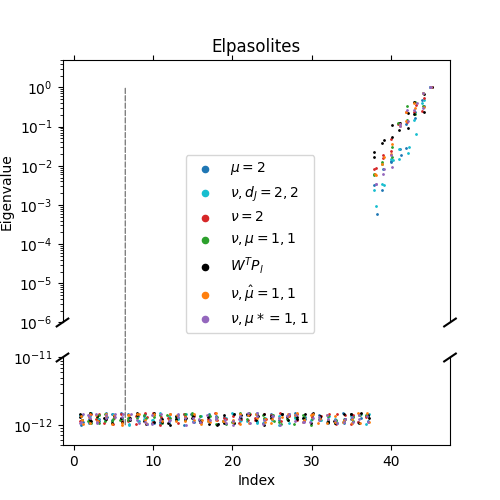

In [26]:
fname = "data/elpasolites_31.json"
with open(fname, "r") as f:
    data_string = f.read()
eig_dic = json.loads(data_string)

min_val = 1e-12

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,5), gridspec_kw={'height_ratios': [3, 1]})

for key, item in eig_dic.items():
    if "Gram" in key:
        continue
    name, label = n2l(key)    
    
    #add small amount of random noise to x and y coords to make data more visible
    pdata = []
    for eigs in item:
        for i, e in enumerate(eigs):
            emax = max(eigs) + min_val
            pdata.append([i+1-0.2+0.4*np.random.uniform(), max([min_val+0.5*min_val*np.random.uniform(), e/emax])])
    pdata = np.array(pdata)      
            
    ax.scatter(pdata[:,0], pdata[:,1], label=label, s=1, c=cdic[name])
    ax2.scatter(pdata[:,0], pdata[:,1], label=label, s=1, c=cdic[name])

#set axes limits, labels, scales etc.
for bax in [ax, ax2]:
    bax.set_yscale("log")
    bax.vlines(6.5, min_val/10, 1e1, ls="--", color="None")
    
ax.set_ylim([1e-6, 5])
ax2.set_ylim([1e-12*0.5, 1e-11])

lgd = ax2.legend(ncol=1, bbox_to_anchor=(0.3, 1.2))
for  x in lgd.legendHandles:
    x._sizes = [20]

ax.set_ylabel("Eigenvalue")
ax2.set_xlabel("Index")
xlims = ax.get_xlim()
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


#draw the axis break
d = .015  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - 3*d, 1 + 3*d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - 3*d, 1 + 3*d), **kwargs)  # bottom-right diagonal

con = ConnectionPatch(xyA=[6.5, 1e-12], xyB=[6.5, 1], coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax, color="grey", ls="--")
ax2.add_artist(con)

#title and save
ax.set_title("Elpasolites")
plt.savefig("Plots/elpasolite_eigs.png", dpi=900)
plt.show()